In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from absl import flags
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Keras to TFlite Conversion

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/generator.h5')
print('loaded')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()
open("/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/mobilenet_pix2pix_lab_fp16.tflite", "wb").write(tflite_model)
# open("/content/mobilenet_pix2pix.tflite", "wb").write(tflite_model)
print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

loaded
INFO:tensorflow:Assets written to: /tmp/tmp5anhbsgv/assets


INFO:tensorflow:Assets written to: /tmp/tmp5anhbsgv/assets


Model size is 32.988693 MBs.


### Saved_model format to TFLite conversion

- This is used when we want fixed shape input for tflite model(eg: (1,256,256,3)). 
- Fixed shape models are also a requirement for GPU Delegates

In [ ]:
model = tf.saved_model.load('/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/generator_savedmodel_format/')
print('loaded')
concrete_func = model.signatures[
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 256, 256, 1]) 
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()
open("/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/mobilenet_pix2pix_lab_fixed_fp16.tflite", "wb").write(tflite_model)
print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

loaded
Model size is 33.024033 MBs.


### Validate tflite model

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/B.Tech Project/codes')
from utils import *

In [ ]:
!unzip '/content/drive/MyDrive/B.Tech Project/Datasets/dataset_1.zip'

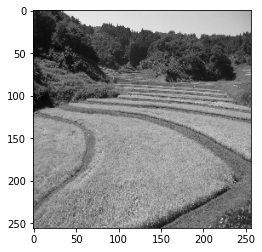

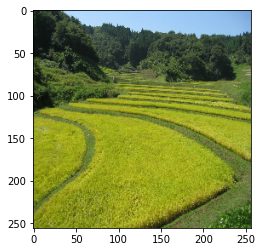

In [ ]:
PATH = '/content/dataset_1/'
inp, re = load_image(PATH+'test/00000170_(6).jpg')
inp, re = resize(inp,re, IMG_HEIGHT, IMG_WIDTH)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(tf.squeeze(inp)/255.0, cmap='gray')
plt.figure()
plt.imshow(re/255.0)

In [ ]:
inp, re = load_image_train(PATH+'test/00000170_(6).jpg')

In [ ]:
def generate_images2(model, test_input, tar):
  start = time.time()
  print(test_input.shape, tar.shape)
  prediction = model(test_input, training=False)
  end = time.time()
  print('Inference Time: ',end-start)
  plt.figure(figsize=(15,15))

  display_list = [tf.squeeze(test_input[0]), tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5,cmap='gray')
    plt.axis('off')
  plt.show()

(1, 256, 256, 1) (1, 256, 256, 3)
Inference Time:  0.05419206619262695


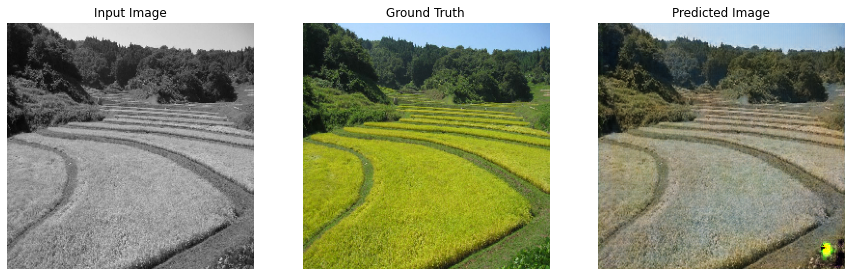

In [ ]:
generate_images2(model,tf.expand_dims(inp, axis=0),tf.expand_dims(re, axis=0))

In [ ]:
# Validate tflite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/mobilenet_pix2pix_lab_fixed.tflite") 
# interpreter = tf.lite.Interpreter(model_path="/content/mobilenet_pix2pix.tflite") 
interpreter.allocate_tensors()
# Get input and output tensors
input_details = interpreter.get_input_details() 
output_details = interpreter.get_output_details()
# Test model on random input data
input_shape = input_details[0]['shape']
print(input_shape)
input_data = np.array(2*np.random.random_sample(input_shape)-1, dtype=np.float32)
# input_data = tf.expand_dims(input_data,axis=0)
print(input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index']) 
print(output_data.shape)
plt.figure(figsize=(5,5))
# plt.imshow(np.squeeze(output_data,axis=0)*0.5 + 0.5,cmap='gray')

[  1 256 256   1]
(1, 256, 256, 1)
(1, 256, 256, 2)


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'input_3',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 256, 256,   1], dtype=int32),
  'shape_signature': array([  1, 256, 256,   1], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_data = (output_data -(-1))/0.007843138 #denormalise
# output_data

In [ ]:
output_data = np.array(output_data,dtype=np.uint8)
# output_data

In [ ]:
plt.imshow(np.squeeze(output_data,axis=0),cmap='gray')

In [ ]:
plt.imshow(np.squeeze(output_data,axis=0)*127.5 + 127.5,cmap='gray')

In [ ]:
np.max(input_data)

0.9999834

### Adding metadata

In [ ]:
!pip install tflite-support

     |████████████████████████████████| 1.1MB 6.3MB/s 
     |████████████████████████████████| 194kB 17.9MB/s 


In [ ]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [ ]:
!mkdir '/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/model_with_metadata'

In [ ]:
# The original selfie2anime.tflite file
MODEL_FILE = "mobilenet_pix2pix_lab.tflite"
# This is where we will export a new .tflite model file with metadata, and a .json file with metadata info
EXPORT_DIR = '/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/model_with_metadata'
# EXPORT_DIR = '/content/md/'

In [ ]:
class MetadataPopulatorForGANModel(object):
  """Populates the metadata for the GAN model."""

  def __init__(self, model_file):
    self.model_file = model_file
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it"""
    self._create_metadata()
    self._populate_metadata()
  
  def _create_metadata(self):
    """Creates the metadata for the GAN model."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = "mobilenet_pix2pix" 
    model_meta.description = ("Colorises black and white images")
    model_meta.version = "v1"
    model_meta.author = ""
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates info for the input, selfie image.
    input_image_meta = _metadata_fb.TensorMetadataT()
    input_image_meta.name = "grayscale_image"
    input_image_meta.description = (
        "The expected image is 256 x 256 black and white image  "
        ". Each value in the tensor is between"
        " -1 and 1.")
    input_image_meta.content = _metadata_fb.ContentT()
    input_image_meta.content.contentProperties = (_metadata_fb.ImagePropertiesT())
    input_image_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.GRAYSCALE)

    input_image_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_image_normalization = _metadata_fb.ProcessUnitT()
    input_image_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_image_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_image_normalization.options.mean = [127.5]
    input_image_normalization.options.std = [127.5]
    input_image_meta.processUnits = [input_image_normalization]
    input_image_stats = _metadata_fb.StatsT()
    input_image_stats.max = [255]
    input_image_stats.min = [0]
    input_image_meta.stats = input_image_stats


    # Creates output info, anime image
    output_image_meta = _metadata_fb.TensorMetadataT()
    output_image_meta.name = "color_image"
    output_image_meta.description = "Image Colorised"
    output_image_meta.content = _metadata_fb.ContentT()
    output_image_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    output_image_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    output_image_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    output_image_normalization = _metadata_fb.ProcessUnitT()
    output_image_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    output_image_normalization.options = _metadata_fb.NormalizationOptionsT()
    output_image_normalization.options.mean = [-1.0]
    output_image_normalization.options.std = [0.007843137255]  # 1/127.5
    output_image_meta.processUnits = [output_image_normalization]
    output_image_stats = _metadata_fb.StatsT()
    output_image_stats.max = [1.0]
    output_image_stats.min = [-1.0]
    output_image_meta.stats = output_image_stats

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_image_meta] 
    subgraph.outputTensorMetadata = [output_image_meta] 
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.populate()

In [ ]:
def populate_metadata(model_file):
  """Populates the metadata using the populator specified.
  Args:
      model_file: valid path to the model file.
      model_type: a type defined in StyleTransferModelType .
  """

  # Populates metadata for the model.
  model_file_basename = os.path.basename(model_file)
  export_path = os.path.join(EXPORT_DIR, model_file_basename)
  tf.io.gfile.copy(model_file, export_path, overwrite=True)

  populator = MetadataPopulatorForGANModel(export_path) 
  populator.populate()

  # Displays the metadata that was just populated into the tflite model.
  displayer = _metadata.MetadataDisplayer.with_model_file(export_path)
  export_json_file = os.path.join(
      EXPORT_DIR,
      os.path.splitext(model_file_basename)[0] + ".json")
  json_file = displayer.get_metadata_json()
  with open(export_json_file, "w") as f:
    f.write(json_file)
  print("Finished populating metadata and associated file to the model:")
  print(export_path)
  print("The metadata json file has been saved to:")
  print(os.path.join(EXPORT_DIR,
                   os.path.splitext(model_file_basename)[0] + ".json"))

In [ ]:
populate_metadata('/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/' + MODEL_FILE)

Finished populating metadata and associated file to the model:
/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/model_with_metadata/mobilenet_pix2pix_lab.tflite
The metadata json file has been saved to:
/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/lab/model_with_metadata/mobilenet_pix2pix_lab.json
